In [1]:
import torch
import numpy as np
import random
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# Import train_test_split from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
import pandas as pd

# Attempt reading the dataset with a specific encoding
try:
    df = pd.read_csv('twitter.csv', encoding='ISO-8859-1')
except UnicodeDecodeError:
    df = pd.read_csv('twitter.csv', encoding='latin1')
# Define meaningful column names
column_names = ['target', 'id', 'date', 'query', 'user', 'text']
df.columns = column_names

# Inspect the first few rows to confirm the structure
df.head()


,target,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
import re

def preprocess(text):
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove mentions and special characters
    text = re.sub(r"(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])", "", text)
    # Convert to lowercase
    return text.lower()

# Apply preprocessing to the text column
df['clean_text'] = df['text'].apply(preprocess)
# Change binary values from 4 to 1
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else x)
# Filter by text length
df = df[df['text'].apply(lambda x: 10 <= len(x.split()) <= 50)]
df.head()

,target,id,date,query,user,text,clean_text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i he...
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time no see yes rains a bit only a ...


In [4]:
# Reduce the original dataset
sample_df = df.sample(frac=0.001, random_state=42)

In [5]:
# Split into train/validation and test sets (80/20)
train_val_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=42)

# Further split the training set into training and validation (80/20)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Print the number of examples in each split for verification
print(f"Training examples: {len(train_df)}")
print(f"Validation examples: {len(val_df)}")
print(f"Test examples: {len(test_df)}")

Training examples: 649
Validation examples: 163
Test examples: 204


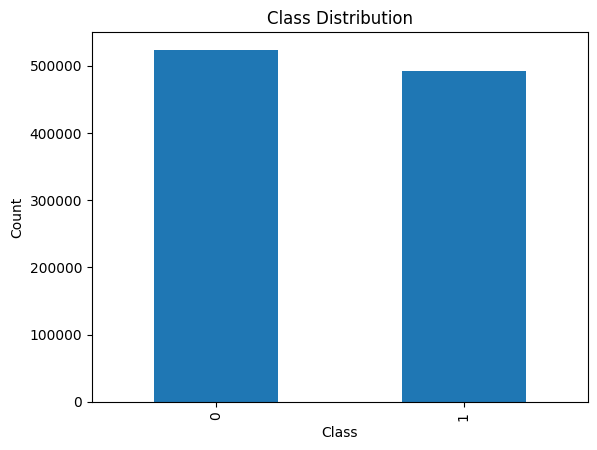

In [8]:
import matplotlib.pyplot as plt

# Assuming your target column is named 'target'
df['target'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


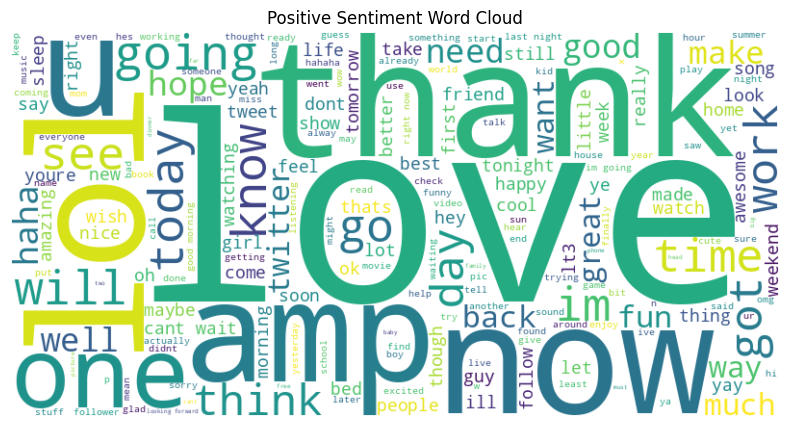

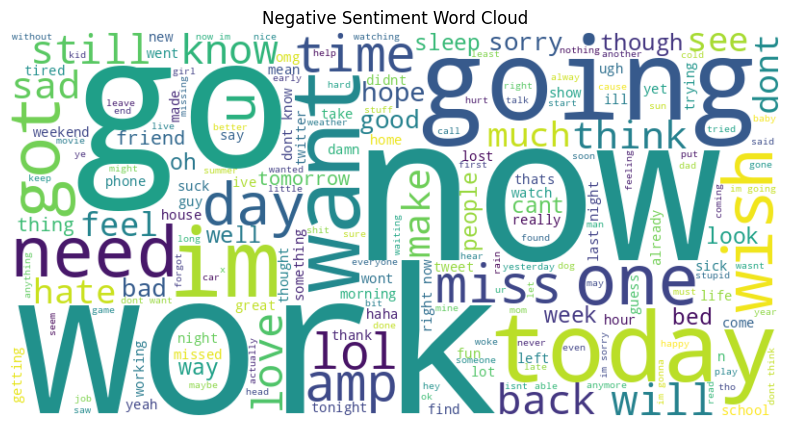

In [9]:
from wordcloud import WordCloud

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for positive and negative classes
positive_text = df[df['target'] == 1]['clean_text']
generate_wordcloud(positive_text, 'Positive Sentiment Word Cloud')

negative_text = df[df['target'] == 0]['clean_text']
generate_wordcloud(negative_text, 'Negative Sentiment Word Cloud')


In [11]:
#!pip install --upgrade pip
#!pip install transformers[torch] --upgrade
#!pip install accelerate --upgrade
#!pip install accelerate -U
#!pip install transformers[torch] -U


import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Necessary Libraries


# Function to calculate metrics (accuracy, F1, precision, recall)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='binary'),
        'recall': recall_score(labels, preds, average='binary'),
        'f1': f1_score(labels, preds, average='binary')
    }


# Load the pretrained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Example function to preprocess and tokenize the text data
# def tokenize_function(examples):
#     return tokenizer(examples['text'], padding='max_length', truncation=True)

# Define a PyTorch dataset class for your data
class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        target = int(self.data.iloc[index]['target'])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.long)
        }

# Tokenize and split your data
# Assuming `df` contains the original data with "text" and "target"
train_df, val_df = train_test_split(sample_df, test_size=0.2, random_state=42)

# Initialize datasets
train_dataset = TwitterDataset(train_df, tokenizer, max_len=64)
val_dataset = TwitterDataset(val_df, tokenizer, max_len=64)

# Load the BERT model (e.g., bert-base-uncased)
model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
import torch
device = torch.device('cpu')
model.to(device)
#train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=4)

# Define training arguments
training_args = TrainingArguments(
    #fp16=True,
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    evaluation_strategy='epoch',  # Evaluate after every epoch
    logging_steps=200,  # Log training loss every 200 steps
    learning_rate=1e-5,
    save_strategy='epoch',  # Save checkpoints after each epoch
    save_total_limit=2,  # Limit number of saved checkpoints
    logging_dir='./logs',  # Directory for TensorBoard logs
    load_best_model_at_end=True,
    log_level='info'
)


# Initialize the Trainer with the dataset and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Add this function to calculate metrics
)

# Start the training process
trainer.train()


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.690370,0.504902,0.450331,0.790698,0.573840
2,No log,0.675764,0.578431,0.000000,0.000000,0.000000
3,No log,0.683460,0.534314,0.466165,0.720930,0.566210


***** Running Evaluation *****
  Num examples = 204
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-26
Configuration saved in ./results/checkpoint-26/config.json
Model weights saved in ./results/checkpoint-26/model.safetensors
***** Running Evaluation *****
  Num examples = 204
  Batch size = 64
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-52
Configuration saved in ./results/checkpoint-52/config.json
Model weights saved in ./results/checkpoint-52/model.safetensors
***** Running Evaluation *****
  Num examples = 204
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-78
Configuration saved in ./results/checkpoint-78/config.json
Model weights saved in ./results/checkp

TrainOutput(global_step=78, training_loss=0.693971193753756, metrics={'train_runtime': 2054.2086, 'train_samples_per_second': 1.186, 'train_steps_per_second': 0.038, 'total_flos': 80117316357120.0, 'train_loss': 0.693971193753756, 'epoch': 3.0})